# chill bro

In [14]:
import torch
import torch.nn as nn
import torchvision
from torch.optim import lr_scheduler
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import Counter

In [15]:
# device configuration (if gpu is available then the process will take place in gpu else cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda)

<module 'torch.cuda' from '/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py'>


In [16]:
# Hyper-parameters
num_epochs = 25
batch_size = 16
learning_rate = 0.001
path="/kaggle/input/vlg-train-data/train_data/"

In [17]:
# custom dataset...
class CustomDataSet(Dataset):
    def __init__(self,path,transform= None):
        self.transform = transform
        self.image_path_list=[]
        self.label_index=[]
        for count, entry in enumerate(os.scandir(path)):
            if entry.is_dir():
                animal_name = entry.path.split('/')[-1]
                # animal_name = os.path.basename(entry.path) try this if above doesn't work according to the operating system path type
                for im in os.scandir(entry.path):
                    if im.is_file():
                        im_path=path + animal_name + "/" + im.name
                        self.image_path_list.append(im_path)
                        self.label_index.append(count)
    def __getitem__(self, index):
         while True:
            try:
                image = Image.open(self.image_path_list[index]).convert("RGB")
                label = self.label_index[index]
                if self.transform:
                    image = self.transform(image) # image is returned after transformation
                return image, label
            except (OSError, UnidentifiedImageError, ValueError) as e:  # incase the image can't be opened or unidentified error occures
                print(f"Skipping corrupted image: {self.image_path_list[index]} | Error: {e}")
    def __len__(self):
        return len(self.image_path_list)

In [18]:
# data augmentation
transform = transforms.Compose(
    [transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = CustomDataSet(path=path,transform=transform)

train_size=int(0.85*len(dataset))
test_size= len(dataset)-train_size

train_set, test_set= random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # trained with complete dataset
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) # 15% data is kept for evaluation

In [19]:
# model
model = models.resnet101(pretrained=True)
num_classes = 50
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# first freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# unfreezing the last convolution layer and classifier head layer
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# criterion and optimizer defining
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate) # optimizes the layer which are not frozen

In [21]:
# lr-scheduler (Multistep lr is used here)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[16,21], gamma=0.9)

....................................................................................................
epoch [1/25], step [100/364], loss: 3.5743
....................................................................................................
epoch [1/25], step [200/364], loss: 3.3715
....................................................................................................
epoch [1/25], step [300/364], loss: 3.0238
....................................................................................................................................................................
epoch [2/25], step [100/364], loss: 2.5720
....................................................................................................
epoch [2/25], step [200/364], loss: 2.9515
....................................................................................................
epoch [2/25], step [300/364], loss: 1.9382
........................................................................

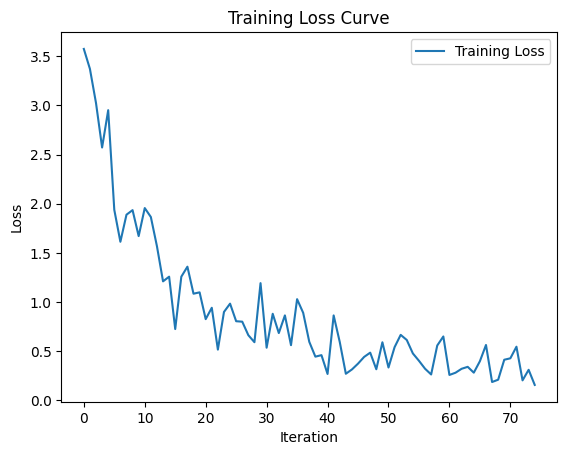

In [22]:
# training loop...
loss_values = []
epoch_list=[]
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(".",end="") # used this to check the status of completion (unnecessary)
        if (i + 1) % 100 == 0: # printing the loss details every 100 epoch
            print()
            print(f"epoch [{epoch + 1}/{num_epochs}], step [{i+1}/{n_total_steps}], loss: {loss.item():.4f}")
            loss_values.append(loss.item())

    scheduler.step()

print("finished training")
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()
# plotted a loss graph every 100 epoch to check the behaviour of the code

In [27]:
# evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted= torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += torch.sum(predicted == labels).item()
        print(".", end="")

    acc = 100.0 * n_correct/n_samples    # evaluation based on 15% data (seen)
    print()
    print(f"accuracy of the model: {acc} %")

AttributeError: 'tuple' object has no attribute 'to'

In [25]:
class_name=[] #class names are listed
for entry in os.scandir(path):
            if entry.is_dir():
                animal_name = entry.path.split('/')[-1]
                class_name.append(animal_name)

In [26]:
# test prediction
test_path = "/kaggle/input/vlg-test/test/"
n_votes = 7  # an image is passed through the model several times and the majority answer is considered

# defining transformations (each time different transformation will take place as the image is passed through the model multiple time) (i might have messed up this thing)
transform = transforms.Compose(
    [transforms.RandomResizedCrop(300, scale=(0.7, 1.0)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# custom dataset for the test data...
class TestDataset(Dataset):
    def __init__(self, test_path, transform=None):
        self.test_path = test_path
        self.transform = transform
        self.image_paths = [entry.path for entry in os.scandir(test_path) if entry.is_file()]
        self.image_names = [entry.name for entry in os.scandir(test_path) if entry.is_file()]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[index]

# initialize the test dataset and dataloader
test_dataset = TestDataset(test_path=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for voting

# store results
results = []
columns = ['image_id', 'class']

# prediction with voting mechanism
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, image_ids in test_loader:
        votes = []  # Store predictions for voting
        images = images.to(device)
        # voting mechanism
        for _ in range(n_votes):
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            votes.append(predicted.item())

        # majority outcome extraction
        final_prediction = Counter(votes).most_common(1)[0][0]
        class_name_pred = class_name[final_prediction]  # class name derived with the index

        results.append({'image_id': image_ids[0], 'class': class_name_pred})
        print(".",end="")

# dataframe creation and saving as csv
df = pd.DataFrame(results, columns=columns)
csv_file_path = '/kaggle/working/test_prediction.csv'
df.to_csv(csv_file_path, index=False)
print("CSV created at:", csv_file_path)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................